In [1]:
import xarray as xr
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
import pickle
import os

In [2]:
def Save_Var(data, save_name):
    with open(str(save_name + ".data"), 'wb') as f:
        pickle.dump(data, f)
        
    try:
        with open(str(save_name + ".data"), 'rb') as f:
            new_data = pickle.load(f)
    except:
        print("Error: saving not successful")
    else:
        print(str(save_name + ".data" + " saved succesfully"))

def Load_Var(save_name):
    with open(save_name, 'rb') as f:
        data = pickle.load(f)
    return data 

In [3]:
def Examine_Nulls(df):
    percent_missing = df.isnull().sum() * 100 / len(df)
    missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})
    missing_value_df.sort_values('percent_missing', inplace=True)
    return missing_value_df

## Load Data

In [4]:
DS = xr.open_dataset('SCDNA_v1.1.nc4')

In [5]:
DS

<xarray.Dataset>
Dimensions:    (lle: 3, nchar: 13, nday: 14610, nsf: 3, nstn: 27276)
Dimensions without coordinates: lle, nchar, nday, nsf, nstn
Data variables:
    ID         (nchar, nstn) |S1 ...
    LLE        (lle, nstn) float32 ...
    date       (nday) int32 ...
    sflag      (nsf, nstn) |S1 ...
    prcp       (nstn, nday) float32 ...
    prcp_flag  (nstn, nday) float64 ...
    prcp_kge   (nstn) float32 ...
    tmin       (nstn, nday) float32 ...
    tmin_flag  (nstn, nday) float64 ...
    tmin_kge   (nstn) float32 ...
    tmax       (nstn, nday) float32 ...
    tmax_flag  (nstn, nday) float64 ...
    tmax_kge   (nstn) float32 ...

In [6]:
IDs = DS.ID.values.astype(str)
stationid = [c2+c3+c4+c5+c6+c7+c8+c9+c10+c11+c12 for (c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12)\
           in zip(IDs[2,:],IDs[3,:],IDs[4,:],IDs[5,:],IDs[6,:],IDs[7,:],IDs[8,:],IDs[9,:],IDs[10,:],\
                  IDs[11,:],IDs[12,:])]
sources = [c0+c1 for (c0,c1) in zip(IDs[0,:],IDs[1,:])]
oid = [source+sid for (source,sid) in zip(sources,stationid)]

In [7]:
np.unique(stationid)

array(['69014093101', '69015093121', '69016093114', ..., 'VQC00679450',
       'VQW00011624', 'VQW00011640'], dtype='<U11')

In [8]:
np.unique(sources)

array(['EC', 'GH', 'GS', 'ME', 'MR'], dtype='<U2')

#### Modify XArray object for easier conversion to a Dataframe

In [9]:
dates = [datetime.strptime(str(date),'%Y%m%d') for date in DS.date.values]
DS = DS.set_coords(['date','ID'])
DS = DS.assign_coords(nstn = oid, nday = dates)

In [10]:
DS.coords['latitude'] = DS.LLE[0,:]
DS.coords['longitude'] = DS.LLE[1,:]
# DS.coords['elevation'] = DS.LLE[2,:]

In [11]:
# IDS = DS.ID.values.astype(str)
# DS.coords['source'] = DS['nstn'].str[0:2]
# DS.coords['ID'] = DS['nstn'].str[2:]

In [12]:
DS = DS.drop_dims(['lle'])
DS = DS.drop_vars("date")
DS = DS.rename_dims(nstn='station', nday='datetime')
DS = DS.rename_vars(nstn='station', nday='datetime')

In [13]:
DS

<xarray.Dataset>
Dimensions:    (datetime: 14610, nchar: 13, nsf: 3, station: 27276)
Coordinates:
    ID         (nchar, station) |S1 b'E' b'E' b'E' b'E' ... b'7' b'7' b'C' b'4'
  * station    (station) <U13 'ECCA001010066' ... 'MRUSW00022514'
  * datetime   (datetime) datetime64[ns] 1979-01-01 1979-01-02 ... 2018-12-31
    latitude   (station) float32 48.87 48.6 48.58 ... 20.9625 47.5083 21.3167
    longitude  (station) float32 -123.28 -123.47 -123.42 ... -115.9461 -158.0667
Dimensions without coordinates: nchar, nsf
Data variables:
    sflag      (nsf, station) |S1 b'C' b'C' b'C' b'C' ... b'Z' b'X' b'U' b'Z'
    prcp       (station, datetime) float32 ...
    prcp_flag  (station, datetime) float64 ...
    prcp_kge   (station) float32 0.92852646 0.9795798 ... nan 0.9233105
    tmin       (station, datetime) float32 ...
    tmin_flag  (station, datetime) float64 ...
    tmin_kge   (station) float32 nan nan nan ... 0.9051904 0.98577374 0.9701442
    tmax       (station, datetime) float32 ...
    tmax_flag  (station, datetime) float64 ...
    tmax_kge   (station) float32 nan nan nan ... 0.90621644 0.99051 0.96932197

In [14]:
DS.datetime.max()

<xarray.DataArray 'datetime' ()>
array('2018-12-31T00:00:00.000000000', dtype='datetime64[ns]')

#### Only select stations w/ temperature and precip data


In [15]:
valid_stns = ~np.isnan(DS.prcp.values).any(axis=1) & ~np.isnan(DS.tmin.values).any(axis=1) & ~np.isnan(DS.tmax.values).any(axis=1)
valid_stns

array([False, False, False, ...,  True, False,  True])

In [16]:
np.sum(valid_stns)

16937

## Matching Stations

#### SCDNA

In [17]:
from pyproj import CRS
import geopandas as gpd
import shapely.geometry as sg

In [18]:
station_table = pd.DataFrame(data={'ID':DS.station.values,
                                   'Latitude':DS.latitude.values,
                                   'Longitude':DS.longitude.values})
station_table

ID   Latitude   Longitude
0      ECCA001010066  48.869999 -123.279999
1      ECCA001010960  48.599998 -123.470001
2      ECCA001011467  48.580002 -123.419998
3      ECCA0010114F6  48.570000 -123.389999
4      ECCA001011500  48.939999 -123.739998
...              ...        ...         ...
27271  MRUSC00502457  59.049999 -158.516693
27272  MRUSC00507557  56.247200 -134.644699
27273  MRUSC00513317  20.962500 -156.675293
27274  MRUSR0000INUC  47.508301 -115.946098
27275  MRUSW00022514  21.316700 -158.066696

[27276 rows x 3 columns]

In [19]:
selected_table = station_table.loc[valid_stns]
selected_table

ID   Latitude   Longitude
4      ECCA001011500  48.939999 -123.739998
6      ECCA001011922  48.520000 -123.370003
8      ECCA001012040  48.820000 -124.129997
9      ECCA001012055  48.830002 -124.050003
10     ECCA001012570  48.770000 -123.680000
...              ...        ...         ...
27269  MRUSC00467852  38.383301  -81.833900
27271  MRUSC00502457  59.049999 -158.516693
27272  MRUSC00507557  56.247200 -134.644699
27273  MRUSC00513317  20.962500 -156.675293
27275  MRUSW00022514  21.316700 -158.066696

[16937 rows x 3 columns]

In [20]:
dx = 0.1

In [21]:
selected_table['i'] = [np.round(i/dx)*dx for i in selected_table['Latitude']]
selected_table['j'] = [np.round(i/dx)*dx for i in selected_table['Longitude']]

<ipython-input-21-91047f2b7fd5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_table['i'] = [np.round(i/dx)*dx for i in selected_table['Latitude']]
<ipython-input-21-91047f2b7fd5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_table['j'] = [np.round(i/dx)*dx for i in selected_table['Longitude']]


In [22]:
selected_table

ID   Latitude   Longitude     i      j
4      ECCA001011500  48.939999 -123.739998  48.9 -123.7
6      ECCA001011922  48.520000 -123.370003  48.5 -123.4
8      ECCA001012040  48.820000 -124.129997  48.8 -124.1
9      ECCA001012055  48.830002 -124.050003  48.8 -124.1
10     ECCA001012570  48.770000 -123.680000  48.8 -123.7
...              ...        ...         ...   ...    ...
27269  MRUSC00467852  38.383301  -81.833900  38.4  -81.8
27271  MRUSC00502457  59.049999 -158.516693  59.0 -158.5
27272  MRUSC00507557  56.247200 -134.644699  56.2 -134.6
27273  MRUSC00513317  20.962500 -156.675293  21.0 -156.7
27275  MRUSW00022514  21.316700 -158.066696  21.3 -158.1

[16937 rows x 5 columns]

#### ERA5

In [23]:
era5_df = pd.read_csv('ERA5_2017.csv')

In [24]:
# era5_df.drop('snow_frac', axis=1, inplace=True)

In [25]:
# era5_df['i'] = [np.round(i/dx)*dx for i in era5_df['latitude']]
# era5_df['j'] = [np.round(i/dx)*dx for i in era5_df['longitude']]

In [26]:
# era5_df.drop(['latitude', 'longitude'], axis=1, inplace=True)

In [27]:
edf = era5_df.copy()
edf['time'] = pd.to_datetime(edf['time'])
edf = edf[edf['time'].dt.hour == 1]

In [28]:
edf

time        t2m  hourly_sf  hourly_tp     i     j
0        2017-01-15 01:00:00 -30.946494   0.008270   0.008464  83.1 -74.5
23       2017-02-15 01:00:00 -29.410727   0.004724   0.005078  83.1 -74.5
46       2017-03-15 01:00:00 -22.139319   0.012998   0.011846  83.1 -74.5
69       2017-04-15 01:00:00 -18.381384   0.007089   0.006769  83.1 -74.5
92       2017-05-15 01:00:00  -7.586829   0.132341   0.133723  83.1 -74.5
...                      ...        ...        ...        ...   ...   ...
70386233 2017-08-15 01:00:00  22.813623  -0.000004   0.000000  40.0 -74.1
70386256 2017-09-15 01:00:00  22.123071  -0.000004   0.000000  40.0 -74.1
70386279 2017-10-15 01:00:00  19.171716  -0.000004   0.000000  40.0 -74.1
70386302 2017-11-15 01:00:00   6.578973  -0.000004   0.010155  40.0 -74.1
70386325 2017-12-15 01:00:00  -2.638403  -0.000004   0.000000  40.0 -74.1

[3060276 rows x 6 columns]

#### Merge both dataframes
- Merge on ij coordinates to see which SCDNA stations need to be matched to their ERA5-Land counterparts

In [29]:
merged_df = pd.merge(edf, selected_table, on=['i', 'j'])
merged_df

time        t2m  hourly_sf  hourly_tp     i     j  \
0     2017-01-15 01:00:00 -35.185034   0.004724   0.005078  82.5 -62.3   
1     2017-01-15 01:00:00 -35.185034   0.004724   0.005078  82.5 -62.3   
2     2017-01-15 01:00:00 -35.185034   0.004724   0.005078  82.5 -62.3   
3     2017-02-15 01:00:00 -34.204474  -0.000004   0.000000  82.5 -62.3   
4     2017-02-15 01:00:00 -34.204474  -0.000004   0.000000  82.5 -62.3   
...                   ...        ...        ...        ...   ...   ...   
91435 2017-08-15 01:00:00  22.788751  -0.000004   0.000000  40.0 -74.2   
91436 2017-09-15 01:00:00  22.132745  -0.000004   0.000000  40.0 -74.2   
91437 2017-10-15 01:00:00  19.026697  -0.000004   0.000000  40.0 -74.2   
91438 2017-11-15 01:00:00   6.377344  -0.000004   0.006769  40.0 -74.2   
91439 2017-12-15 01:00:00  -3.134192  -0.000004   0.000000  40.0 -74.2   

                  ID   Latitude  Longitude  
0      ECCA002400305  82.500000 -62.330002  
1      GHCA002400300  82.516701 -62.283298  
2      GS71082399999  82.517776 -62.280556  
3      ECCA002400305  82.500000 -62.330002  
4      GHCA002400300  82.516701 -62.283298  
...              ...        ...        ...  
91435  GHUSC00288816  39.950001 -74.216698  
91436  GHUSC00288816  39.950001 -74.216698  
91437  GHUSC00288816  39.950001 -74.216698  
91438  GHUSC00288816  39.950001 -74.216698  
91439  GHUSC00288816  39.950001 -74.216698  

[91440 rows x 9 columns]

In [30]:
np.unique(merged_df['ID']).shape

(7620,)

In [31]:
# matched_coords = zip(merged_df.i, merged_df.j)
matched_stations = np.unique(merged_df.ID)

In [32]:
final_stns = []
for i in range(len(valid_stns)):
    final_stns.append(valid_stns[i] and (station_table['ID'][i] in matched_stations))

In [33]:
np.sum(final_stns)

7620

In [34]:
Save_Var(final_stns, 'final_stns')

final_stns.data saved succesfully


#### Now merge full SCDNA data with  full ERA5-Land Data

In [35]:
# Can later use this as our 'batch size'
n_samples = 1000
np.random.seed(123)
indices = np.random.choice(np.sum(final_stns), n_samples, replace=False)  

In [36]:
precip_ = DS.prcp.loc[final_stns][indices]
precip_df = precip_.to_dataframe().reset_index()
precip_df['datetime'] = pd.to_datetime(precip_df['datetime'])
precip_df = precip_df[precip_df['datetime'].dt.year == 2017]
# precip_df = precip_df[precip_df['prcp'] >= 1]

tmin_ = DS.tmin.loc[final_stns][indices]
tmin_df = tmin_.to_dataframe().reset_index()
tmin_df['datetime'] = pd.to_datetime(tmin_df['datetime'])
tmin_df = tmin_df[tmin_df['datetime'].dt.year == 2017]

tmax_ = DS.tmax.loc[final_stns][indices]
tmax_df = tmax_.to_dataframe().reset_index()
tmax_df['datetime'] = pd.to_datetime(tmax_df['datetime'])
tmax_df = tmax_df[tmax_df['datetime'].dt.year == 2017]

full_df = pd.merge(
    precip_df,
    pd.merge(tmin_df, tmax_df, on=['station','latitude', 'longitude', 'datetime']),
    on=['station','latitude', 'longitude','datetime']
)
# full_df.set_index(['station','latitude', 'longitude', 'elevation', 'datetime'], inplace=True)
full_df

station   datetime   latitude   longitude    prcp  tmin  \
0       GHUSC00306314 2017-01-01  43.462200  -76.493301   3.800   0.6   
1       GHUSC00306314 2017-01-02  43.462200  -76.493301   0.000  -3.9   
2       GHUSC00306314 2017-01-03  43.462200  -76.493301  10.900   1.1   
3       GHUSC00306314 2017-01-04  43.462200  -76.493301   6.100  -3.3   
4       GHUSC00306314 2017-01-05  43.462200  -76.493301   0.000  -6.1   
...               ...        ...        ...         ...     ...   ...   
364995  GS71966099999 2017-12-27  64.043053 -139.127777   0.000 -37.0   
364996  GS71966099999 2017-12-28  64.043053 -139.127777   0.000 -38.0   
364997  GS71966099999 2017-12-29  64.043053 -139.127777   0.254 -41.5   
364998  GS71966099999 2017-12-30  64.043053 -139.127777   0.000 -43.0   
364999  GS71966099999 2017-12-31  64.043053 -139.127777   0.000 -40.5   

             tmax  
0        3.900000  
1        2.800000  
2        3.300000  
3        3.900000  
4       -3.300000  
...           ...  
364995 -34.000000  
364996 -34.000000  
364997 -35.000000  
364998 -38.277779  
364999 -34.000000  

[365000 rows x 7 columns]

In [37]:
full_df['i'] = [np.round(i/dx)*dx for i in full_df['latitude']]
full_df['j'] = [np.round(i/dx)*dx for i in full_df['longitude']]

In [38]:
# full_df.drop(['longitude', 'latitude'], axis=1, inplace=True)
full_df['datetime'] = pd.to_datetime(full_df['datetime'])
full_df

station   datetime   latitude   longitude    prcp  tmin  \
0       GHUSC00306314 2017-01-01  43.462200  -76.493301   3.800   0.6   
1       GHUSC00306314 2017-01-02  43.462200  -76.493301   0.000  -3.9   
2       GHUSC00306314 2017-01-03  43.462200  -76.493301  10.900   1.1   
3       GHUSC00306314 2017-01-04  43.462200  -76.493301   6.100  -3.3   
4       GHUSC00306314 2017-01-05  43.462200  -76.493301   0.000  -6.1   
...               ...        ...        ...         ...     ...   ...   
364995  GS71966099999 2017-12-27  64.043053 -139.127777   0.000 -37.0   
364996  GS71966099999 2017-12-28  64.043053 -139.127777   0.000 -38.0   
364997  GS71966099999 2017-12-29  64.043053 -139.127777   0.254 -41.5   
364998  GS71966099999 2017-12-30  64.043053 -139.127777   0.000 -43.0   
364999  GS71966099999 2017-12-31  64.043053 -139.127777   0.000 -40.5   

             tmax     i      j  
0        3.900000  43.5  -76.5  
1        2.800000  43.5  -76.5  
2        3.300000  43.5  -76.5  
3        3.900000  43.5  -76.5  
4       -3.300000  43.5  -76.5  
...           ...   ...    ...  
364995 -34.000000  64.0 -139.1  
364996 -34.000000  64.0 -139.1  
364997 -35.000000  64.0 -139.1  
364998 -38.277779  64.0 -139.1  
364999 -34.000000  64.0 -139.1  

[365000 rows x 9 columns]

In [39]:
full_df.rename(columns={'datetime':'date'}, inplace=True)
full_df

station       date   latitude   longitude    prcp  tmin  \
0       GHUSC00306314 2017-01-01  43.462200  -76.493301   3.800   0.6   
1       GHUSC00306314 2017-01-02  43.462200  -76.493301   0.000  -3.9   
2       GHUSC00306314 2017-01-03  43.462200  -76.493301  10.900   1.1   
3       GHUSC00306314 2017-01-04  43.462200  -76.493301   6.100  -3.3   
4       GHUSC00306314 2017-01-05  43.462200  -76.493301   0.000  -6.1   
...               ...        ...        ...         ...     ...   ...   
364995  GS71966099999 2017-12-27  64.043053 -139.127777   0.000 -37.0   
364996  GS71966099999 2017-12-28  64.043053 -139.127777   0.000 -38.0   
364997  GS71966099999 2017-12-29  64.043053 -139.127777   0.254 -41.5   
364998  GS71966099999 2017-12-30  64.043053 -139.127777   0.000 -43.0   
364999  GS71966099999 2017-12-31  64.043053 -139.127777   0.000 -40.5   

             tmax     i      j  
0        3.900000  43.5  -76.5  
1        2.800000  43.5  -76.5  
2        3.300000  43.5  -76.5  
3        3.900000  43.5  -76.5  
4       -3.300000  43.5  -76.5  
...           ...   ...    ...  
364995 -34.000000  64.0 -139.1  
364996 -34.000000  64.0 -139.1  
364997 -35.000000  64.0 -139.1  
364998 -38.277779  64.0 -139.1  
364999 -34.000000  64.0 -139.1  

[365000 rows x 9 columns]

In [40]:
# era5_df['time'] = pd.to_datetime(era5_df['time'])
# era5_df['date'] = [d.date() for d in era5_df['time']]
# era5_df['time'] = [d.time() for d in era5_df['time']]
# era5_df

time        t2m  hourly_sf  hourly_tp     i     j        date
0         01:00:00 -30.946494   0.008270   0.008464  83.1 -74.5  2017-01-15
1         02:00:00 -31.110846   0.007089   0.006769  83.1 -74.5  2017-01-15
2         03:00:00 -31.012778   0.008270   0.008464  83.1 -74.5  2017-01-15
3         04:00:00 -30.768332   0.009455   0.008464  83.1 -74.5  2017-01-15
4         05:00:00 -30.871909   0.008270   0.008464  83.1 -74.5  2017-01-15
...            ...        ...        ...        ...   ...   ...         ...
70386343  19:00:00  -1.543188   0.140615   0.142187  40.0 -74.1  2017-12-15
70386344  20:00:00  -2.324896   0.360403   0.360541  40.0 -74.1  2017-12-15
70386345  21:00:00  -2.987799   0.919320   0.919133  40.0 -74.1  2017-12-15
70386346  22:00:00  -3.522284   1.490053   1.491264  40.0 -74.1  2017-12-15
70386347  23:00:00  -3.692175   1.566861   1.567434  40.0 -74.1  2017-12-15

[70386348 rows x 7 columns]

In [41]:
# era5_df['date'] = pd.to_datetime(era5_df['date'])
# era5_df

time        t2m  hourly_sf  hourly_tp     i     j       date
0         01:00:00 -30.946494   0.008270   0.008464  83.1 -74.5 2017-01-15
1         02:00:00 -31.110846   0.007089   0.006769  83.1 -74.5 2017-01-15
2         03:00:00 -31.012778   0.008270   0.008464  83.1 -74.5 2017-01-15
3         04:00:00 -30.768332   0.009455   0.008464  83.1 -74.5 2017-01-15
4         05:00:00 -30.871909   0.008270   0.008464  83.1 -74.5 2017-01-15
...            ...        ...        ...        ...   ...   ...        ...
70386343  19:00:00  -1.543188   0.140615   0.142187  40.0 -74.1 2017-12-15
70386344  20:00:00  -2.324896   0.360403   0.360541  40.0 -74.1 2017-12-15
70386345  21:00:00  -2.987799   0.919320   0.919133  40.0 -74.1 2017-12-15
70386346  22:00:00  -3.522284   1.490053   1.491264  40.0 -74.1 2017-12-15
70386347  23:00:00  -3.692175   1.566861   1.567434  40.0 -74.1 2017-12-15

[70386348 rows x 7 columns]

In [69]:
era5_df.to_csv("era5_df_2017.csv")

In [42]:
era5_processed = pd.merge(full_df, era5_df, on=['i', 'j', 'date'])

In [43]:
era5_processed

station       date   latitude   longitude   prcp       tmin  \
0       GHUSC00306314 2017-01-15  43.462200  -76.493301  0.000  -5.600000   
1       GHUSC00306314 2017-01-15  43.462200  -76.493301  0.000  -5.600000   
2       GHUSC00306314 2017-01-15  43.462200  -76.493301  0.000  -5.600000   
3       GHUSC00306314 2017-01-15  43.462200  -76.493301  0.000  -5.600000   
4       GHUSC00306314 2017-01-15  43.462200  -76.493301  0.000  -5.600000   
...               ...        ...        ...         ...    ...        ...   
275995  GS71966099999 2017-12-15  64.043053 -139.127777  8.636 -10.111111   
275996  GS71966099999 2017-12-15  64.043053 -139.127777  8.636 -10.111111   
275997  GS71966099999 2017-12-15  64.043053 -139.127777  8.636 -10.111111   
275998  GS71966099999 2017-12-15  64.043053 -139.127777  8.636 -10.111111   
275999  GS71966099999 2017-12-15  64.043053 -139.127777  8.636 -10.111111   

            tmax     i      j      time       t2m  hourly_sf  hourly_tp  
0      -0.600000  43.5  -76.5  01:00:00 -0.145544  -0.000004   0.000000  
1      -0.600000  43.5  -76.5  02:00:00 -0.684149   0.000000   0.000000  
2      -0.600000  43.5  -76.5  03:00:00 -0.707648   0.000000   0.000000  
3      -0.600000  43.5  -76.5  04:00:00 -0.859564   0.000000   0.000000  
4      -0.600000  43.5  -76.5  05:00:00 -0.885809   0.000000   0.000000  
...          ...   ...    ...       ...       ...        ...        ...  
275995 -4.111111  64.0 -139.1  19:00:00 -6.339697   0.003542   0.001695  
275996 -4.111111  64.0 -139.1  20:00:00 -7.219458   0.002362   0.003383  
275997 -4.111111  64.0 -139.1  21:00:00 -7.880988   0.002366   0.001695  
275998 -4.111111  64.0 -139.1  22:00:00 -8.822882   0.001181   0.001691  
275999 -4.111111  64.0 -139.1  23:00:00 -9.706793   0.000000   0.001691  

[276000 rows x 13 columns]

In [44]:
era5_processed = era5_processed.set_index(['station', 'i', 'j', 'date', 'time'])

In [45]:
era5_processed

latitude   longitude   prcp  \
station       i    j      date       time                                     
GHUSC00306314 43.5 -76.5  2017-01-15 01:00:00  43.462200  -76.493301  0.000   
                                     02:00:00  43.462200  -76.493301  0.000   
                                     03:00:00  43.462200  -76.493301  0.000   
                                     04:00:00  43.462200  -76.493301  0.000   
                                     05:00:00  43.462200  -76.493301  0.000   
...                                                  ...         ...    ...   
GS71966099999 64.0 -139.1 2017-12-15 19:00:00  64.043053 -139.127777  8.636   
                                     20:00:00  64.043053 -139.127777  8.636   
                                     21:00:00  64.043053 -139.127777  8.636   
                                     22:00:00  64.043053 -139.127777  8.636   
                                     23:00:00  64.043053 -139.127777  8.636   

                                                    tmin      tmax       t2m  \
station       i    j      date       time                                      
GHUSC00306314 43.5 -76.5  2017-01-15 01:00:00  -5.600000 -0.600000 -0.145544   
                                     02:00:00  -5.600000 -0.600000 -0.684149   
                                     03:00:00  -5.600000 -0.600000 -0.707648   
                                     04:00:00  -5.600000 -0.600000 -0.859564   
                                     05:00:00  -5.600000 -0.600000 -0.885809   
...                                                  ...       ...       ...   
GS71966099999 64.0 -139.1 2017-12-15 19:00:00 -10.111111 -4.111111 -6.339697   
                                     20:00:00 -10.111111 -4.111111 -7.219458   
                                     21:00:00 -10.111111 -4.111111 -7.880988   
                                     22:00:00 -10.111111 -4.111111 -8.822882   
                                     23:00:00 -10.111111 -4.111111 -9.706793   

                                               hourly_sf  hourly_tp  
station       i    j      date       time                            
GHUSC00306314 43.5 -76.5  2017-01-15 01:00:00  -0.000004   0.000000  
                                     02:00:00   0.000000   0.000000  
                                     03:00:00   0.000000   0.000000  
                                     04:00:00   0.000000   0.000000  
                                     05:00:00   0.000000   0.000000  
...                                                  ...        ...  
GS71966099999 64.0 -139.1 2017-12-15 19:00:00   0.003542   0.001695  
                                     20:00:00   0.002362   0.003383  
                                     21:00:00   0.002366   0.001695  
                                     22:00:00   0.001181   0.001691  
                                     23:00:00   0.000000   0.001691  

[276000 rows x 8 columns]

## Scaling and Predictions

In [47]:
# Separate into station/date groups
dfs = []
for name, group in era5_processed.groupby(level=[0, 1, 2]):
    for name_, group_ in group.groupby(level=[3]):
        dfs.append(group_)

In [48]:
# Load ERA5 model
from sklearn.isotonic import IsotonicRegression 
ir_era5 = Load_Var('ir_era5_2017.data')

In [49]:
# Function is applied to each mini df in dfs
def Scale_Temp(df):
    if df['t2m'].max() == df['t2m'].min():
        df['adjusted_temp'] =  df.apply(lambda row: row['tmin'] + (row['tmax'] - row['tmin']) * (row['time'].hour/23), axis=1)
    else:
        a = (np.unique(df['tmax'])[0] - np.unique(df['tmin'])[0])/(df['t2m'].max() - df['t2m'].min())
        b = np.unique(df['tmax'])[0] - a * df['t2m'].max()
        df['adjusted_temp'] = df.apply(lambda row: a * row['t2m'] + b, axis=1)
    return df
        
def Scale_Precip(df):
    if np.sum(df['hourly_tp']) == 0:
        df['adjusted_precip'] = df['hourly_tp'].map(lambda x: x/24)
    else:
        c = np.unique(df['prcp'])[0] / np.sum(df['hourly_tp'])
        df['adjusted_precip'] = df['hourly_tp'].map(lambda x: c*x)
    return df

def replace_nulls(x):
    if pd.isnull(x['preds_iso']) is True:
        if x['adjusted_temp'] > 0:
            return 0
        elif x['adjusted_temp'] < 0:
            return 1
    else:
        return x['preds_iso']

adjusted_dfs = []

for df in dfs:    
    assert np.unique(df['tmax']).shape[0] == 1 and np.unique(df['tmin']).shape[0] == 1 and np.unique(df['prcp']).shape[0] == 1 
    df = Scale_Temp(df)
    df = Scale_Precip(df)
    df['preds_iso'] = ir_era5.predict(df['adjusted_temp'])
    df['preds_iso'] = df.apply(replace_nulls, axis=1)
    df['predicted_snow'] = df['preds_iso'] * df['adjusted_precip']
    adjusted_dfs.append(df)

In [50]:
scaled_df = pd.concat(adjusted_dfs)

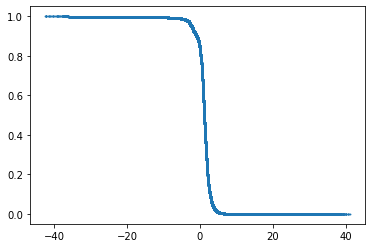

In [51]:
plt.scatter(scaled_df['adjusted_temp'], scaled_df['preds_iso'], s=0.7)

In [52]:
Examine_Nulls(scaled_df)

column_name  percent_missing
latitude                latitude              0.0
longitude              longitude              0.0
prcp                        prcp              0.0
tmin                        tmin              0.0
tmax                        tmax              0.0
t2m                          t2m              0.0
hourly_sf              hourly_sf              0.0
hourly_tp              hourly_tp              0.0
adjusted_temp      adjusted_temp              0.0
adjusted_precip  adjusted_precip              0.0
preds_iso              preds_iso              0.0
predicted_snow    predicted_snow              0.0

In [53]:
final_dfs = []
for df in adjusted_dfs:
    daily_snow_frac = np.sum(df.preds_iso * df.adjusted_precip)/np.unique(df.prcp)[0]
    df['daily_snow_frac'] = np.tile(daily_snow_frac, df.shape[0])
    
    daily_snow = np.sum(df['predicted_snow'])
    df['daily_snow'] = np.tile(daily_snow, df.shape[0])
    final_dfs.append(df)

<ipython-input-53-abc20b29293c>:3: RuntimeWarning: invalid value encountered in double_scalars
  daily_snow_frac = np.sum(df.preds_iso * df.adjusted_precip)/np.unique(df.prcp)[0]
<ipython-input-53-abc20b29293c>:3: RuntimeWarning: divide by zero encountered in double_scalars
  daily_snow_frac = np.sum(df.preds_iso * df.adjusted_precip)/np.unique(df.prcp)[0]


In [54]:
final_df = pd.concat(final_dfs)

In [55]:
final_df

latitude   longitude  prcp  \
station       i    j      date       time                                    
ECCA001012570 48.8 -123.7 2017-01-15 01:00:00  48.770000 -123.680000   0.0   
                                     02:00:00  48.770000 -123.680000   0.0   
                                     03:00:00  48.770000 -123.680000   0.0   
                                     04:00:00  48.770000 -123.680000   0.0   
                                     05:00:00  48.770000 -123.680000   0.0   
...                                                  ...         ...   ...   
MRUSC00215838 45.0 -93.4  2017-12-15 19:00:00  45.009998  -93.379204   1.5   
                                     20:00:00  45.009998  -93.379204   1.5   
                                     21:00:00  45.009998  -93.379204   1.5   
                                     22:00:00  45.009998  -93.379204   1.5   
                                     23:00:00  45.009998  -93.379204   1.5   

                                                   tmin      tmax       t2m  \
station       i    j      date       time                                     
ECCA001012570 48.8 -123.7 2017-01-15 01:00:00 -8.685163  4.865582  0.458002   
                                     02:00:00 -8.685163  4.865582 -1.070868   
                                     03:00:00 -8.685163  4.865582 -2.359412   
                                     04:00:00 -8.685163  4.865582 -3.058234   
                                     05:00:00 -8.685163  4.865582 -3.581671   
...                                                 ...       ...       ...   
MRUSC00215838 45.0 -93.4  2017-12-15 19:00:00 -6.100000 -1.700000 -2.757178   
                                     20:00:00 -6.100000 -1.700000 -2.525153   
                                     21:00:00 -6.100000 -1.700000 -2.218542   
                                     22:00:00 -6.100000 -1.700000 -2.489233   
                                     23:00:00 -6.100000 -1.700000 -3.085852   

                                               hourly_sf  hourly_tp  \
station       i    j      date       time                             
ECCA001012570 48.8 -123.7 2017-01-15 01:00:00  -0.000004   0.000000   
                                     02:00:00   0.000000   0.000000   
                                     03:00:00   0.000000   0.000000   
                                     04:00:00   0.000000   0.000000   
                                     05:00:00   0.000000   0.000000   
...                                                  ...        ...   
MRUSC00215838 45.0 -93.4  2017-12-15 19:00:00   0.011817   0.011846   
                                     20:00:00   0.007089   0.006773   
                                     21:00:00   0.002366   0.003386   
                                     22:00:00   0.005908   0.006769   
                                     23:00:00   0.010632   0.010155   

                                               adjusted_temp  adjusted_precip  \
station       i    j      date       time                                       
ECCA001012570 48.8 -123.7 2017-01-15 01:00:00      -0.797168         0.000000   
                                     02:00:00      -3.250682         0.000000   
                                     03:00:00      -5.318523         0.000000   
                                     04:00:00      -6.439986         0.000000   
                                     05:00:00      -7.279993         0.000000   
...                                                      ...              ...   
MRUSC00215838 45.0 -93.4  2017-12-15 19:00:00      -2.097047         0.080137   
                                     20:00:00      -1.926013         0.045814   
                                     21:00:00      -1.700000         0.022907   
                                     22:00:00      -1.899536         0.045789   
                                     23:00:00      -2.339324         0.068696   

                           

In [56]:
Examine_Nulls(final_df)

column_name  percent_missing
latitude                latitude         0.000000
longitude              longitude         0.000000
prcp                        prcp         0.000000
tmin                        tmin         0.000000
tmax                        tmax         0.000000
t2m                          t2m         0.000000
hourly_sf              hourly_sf         0.000000
hourly_tp              hourly_tp         0.000000
adjusted_temp      adjusted_temp         0.000000
adjusted_precip  adjusted_precip         0.000000
preds_iso              preds_iso         0.000000
predicted_snow    predicted_snow         0.000000
daily_snow            daily_snow         0.000000
daily_snow_frac  daily_snow_frac        64.433333

In [57]:
final_df.to_csv('final_df.csv')

In [ ]:
full_df[]

### Checking

In [58]:
final_df.reset_index().station.value_counts()

GHUSC00137664    276
ECCA005050920    276
GHUSW00004787    276
GHUSS0045M07S    276
GHUSC00398980    276
                ... 
GHUSC00234544    276
GHUSS0010C03S    276
ECCA001163400    276
GHUSC00254900    276
GHUSW00014825    276
Name: station, Length: 1000, dtype: int64

In [59]:
j = 0
for df in final_dfs:
    if df['t2m'].max() == df['t2m'].min():
        print(j, ": Hourly max temp = hourly min temp")
    elif np.sum(df['hourly_tp']) == 0:
        print(j, ": Daily precipitation = 0")
    j += 1

12 : Daily precipitation = 0
24 : Daily precipitation = 0
132 : Daily precipitation = 0
144 : Daily precipitation = 0
156 : Daily precipitation = 0
168 : Daily precipitation = 0
180 : Daily precipitation = 0
592 : Daily precipitation = 0
604 : Daily precipitation = 0
660 : Daily precipitation = 0
661 : Daily precipitation = 0
672 : Daily precipitation = 0
684 : Daily precipitation = 0
685 : Daily precipitation = 0
696 : Daily precipitation = 0
697 : Daily precipitation = 0
708 : Daily precipitation = 0
719 : Daily precipitation = 0
720 : Daily precipitation = 0
732 : Daily precipitation = 0
733 : Daily precipitation = 0
741 : Daily precipitation = 0
744 : Daily precipitation = 0
756 : Daily precipitation = 0
757 : Daily precipitation = 0
768 : Daily precipitation = 0
780 : Daily precipitation = 0
792 : Daily precipitation = 0
793 : Daily precipitation = 0
801 : Daily precipitation = 0
805 : Daily precipitation = 0
817 : Daily precipitation = 0
828 : Daily precipitation = 0
829 : Daily 

3853 : Daily precipitation = 0
3856 : Daily precipitation = 0
3865 : Daily precipitation = 0
3868 : Daily precipitation = 0
3877 : Daily precipitation = 0
3889 : Daily precipitation = 0
3892 : Daily precipitation = 0
3900 : Daily precipitation = 0
3901 : Daily precipitation = 0
3912 : Daily precipitation = 0
3913 : Daily precipitation = 0
3924 : Daily precipitation = 0
3925 : Daily precipitation = 0
3936 : Daily precipitation = 0
3937 : Daily precipitation = 0
3948 : Daily precipitation = 0
3949 : Daily precipitation = 0
3960 : Daily precipitation = 0
3961 : Daily precipitation = 0
3964 : Daily precipitation = 0
3972 : Daily precipitation = 0
3984 : Daily precipitation = 0
3988 : Daily precipitation = 0
3996 : Daily precipitation = 0
4008 : Daily precipitation = 0
4009 : Daily precipitation = 0
4012 : Daily precipitation = 0
4020 : Daily precipitation = 0
4032 : Daily precipitation = 0
4036 : Daily precipitation = 0
4044 : Daily precipitation = 0
4057 : Daily precipitation = 0
4060 : D

6012 : Daily precipitation = 0
6013 : Daily precipitation = 0
6021 : Daily precipitation = 0
6024 : Daily precipitation = 0
6025 : Daily precipitation = 0
6028 : Daily precipitation = 0
6036 : Daily precipitation = 0
6037 : Daily precipitation = 0
6048 : Daily precipitation = 0
6049 : Daily precipitation = 0
6060 : Daily precipitation = 0
6061 : Daily precipitation = 0
6072 : Daily precipitation = 0
6073 : Daily precipitation = 0
6084 : Daily precipitation = 0
6085 : Daily precipitation = 0
6096 : Daily precipitation = 0
6097 : Daily precipitation = 0
6108 : Daily precipitation = 0
6109 : Daily precipitation = 0
6112 : Daily precipitation = 0
6120 : Daily precipitation = 0
6121 : Daily precipitation = 0
6129 : Daily precipitation = 0
6132 : Daily precipitation = 0
6133 : Daily precipitation = 0
6136 : Daily precipitation = 0
6144 : Daily precipitation = 0
6145 : Daily precipitation = 0
6153 : Daily precipitation = 0
6156 : Daily precipitation = 0
6157 : Daily precipitation = 0
6168 : D

8065 : Daily precipitation = 0
8073 : Daily precipitation = 0
8075 : Daily precipitation = 0
8076 : Daily precipitation = 0
8077 : Daily precipitation = 0
8085 : Daily precipitation = 0
8087 : Daily precipitation = 0
8088 : Daily precipitation = 0
8089 : Daily precipitation = 0
8100 : Daily precipitation = 0
8101 : Daily precipitation = 0
8109 : Daily precipitation = 0
8111 : Daily precipitation = 0
8113 : Daily precipitation = 0
8121 : Daily precipitation = 0
8123 : Daily precipitation = 0
8124 : Daily precipitation = 0
8125 : Daily precipitation = 0
8133 : Daily precipitation = 0
8135 : Daily precipitation = 0
8136 : Daily precipitation = 0
8137 : Daily precipitation = 0
8145 : Daily precipitation = 0
8147 : Daily precipitation = 0
8148 : Daily precipitation = 0
8149 : Daily precipitation = 0
8157 : Daily precipitation = 0
8159 : Daily precipitation = 0
8280 : Daily precipitation = 0
8281 : Daily precipitation = 0
8289 : Daily precipitation = 0
8291 : Daily precipitation = 0
8293 : D

9684 : Daily precipitation = 0
9693 : Daily precipitation = 0
9696 : Daily precipitation = 0
9705 : Daily precipitation = 0
9708 : Daily precipitation = 0
9712 : Daily precipitation = 0
9720 : Daily precipitation = 0
9721 : Daily precipitation = 0
9736 : Daily precipitation = 0
9748 : Daily precipitation = 0
9756 : Daily precipitation = 0
9757 : Daily precipitation = 0
9769 : Daily precipitation = 0
9772 : Daily precipitation = 0
9808 : Daily precipitation = 0
9949 : Daily precipitation = 0
9957 : Daily precipitation = 0
9960 : Daily precipitation = 0
9972 : Daily precipitation = 0
9973 : Daily precipitation = 0
9981 : Daily precipitation = 0
9988 : Daily precipitation = 0
10008 : Daily precipitation = 0
10044 : Daily precipitation = 0
10081 : Daily precipitation = 0
10141 : Daily precipitation = 0
10156 : Daily precipitation = 0
10168 : Daily precipitation = 0
10176 : Daily precipitation = 0
10177 : Daily precipitation = 0
10185 : Daily precipitation = 0
10192 : Daily precipitation = 

In [60]:
np.sum(final_dfs[5].adjusted_precip)

14.702385902404785

## Mapping

In [61]:
import shapely.geometry as sg # Operations on shapes (points, lines and polygons)
from pyproj import CRS # Coordinate Reference System (map projections)
import geopandas as gpd # Geospatial extension of Pandas

In [62]:
ll_crs = CRS.from_proj4("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")

def get_gdf(df, y='Latitude', x='Longitude', crs=ll_crs):
    df['geometry'] = [sg.Point(x,y) for (x,y) in df[[x, y]].values] # Iterate over coordinates, construct Shapely Point
    gdf = gpd.GeoDataFrame(df) # Make Pandas DataFrame a GeoPandas GeoDataFrame
    gdf.crs = crs # Initialize coordinate reference system (crs)
    return gdf

In [63]:
station_df = final_df.groupby(['station', 'latitude', 'longitude']).agg('median').reset_index()
station_df

station   latitude   longitude      prcp      tmin       tmax  \
0    ECCA001012570  48.770000 -123.680000  0.550904  4.637982  13.406633   
1    ECCA001014820  48.570000 -123.529999  2.200000  4.650000   9.450000   
2    ECCA001016992  48.820000 -123.480003  0.397945  4.156398  12.230030   
3    ECCA001017254  48.380001 -123.919998  1.300000  7.100000  11.250000   
4    ECCA001021850  49.310001 -124.430000  0.935484  3.384459  12.595865   
..             ...        ...         ...       ...       ...        ...   
995  MRCA006137306  43.119999  -79.250000  0.000000  3.586419  22.940548   
996  MRCA007026839  45.430000  -73.930000  1.850000  4.800000  20.049999   
997  MRCA008100593  46.430000  -64.769997  0.550000  2.250000  11.800000   
998  MRCA008403600  47.520000  -52.779999  0.284701  0.211482  10.633081   
999  MRUSC00215838  45.009998  -93.379204  0.000000  7.500000  16.100000   

           t2m  hourly_sf  hourly_tp  adjusted_temp  adjusted_precip  \
0     7.719736        0.0   0.005078       7.815711         0.000000   
1     8.428247        0.0   0.003386       6.995949         0.001830   
2     8.530450        0.0   0.003386       7.310191         0.000000   
3     7.414514        0.0   0.014387       8.892623         0.003446   
4     7.752206        0.0   0.020312       6.953486         0.011114   
..         ...        ...        ...            ...              ...   
995   9.897012        0.0   0.001691       9.306434         0.000000   
996   9.465433        0.0   0.001691       9.105822         0.000000   
997   5.711649        0.0   0.000000       5.379943         0.000000   
998   4.267725        0.0   0.000000       3.564972         0.000000   
999  12.014230        0.0   0.000000      10.934853         0.000000   

     preds_iso  predicted_snow  daily_snow_frac  daily_snow  
0     0.000712    0.000000e+00         0.003962    0.000165  
1     0.001632    4.164250e-07         0.004790    0.005650  
2     0.001141    0.000000e+00         0.003966    0.001343  
3     0.000265    7.212967e-07         0.000451    0.000341  
4     0.001571    7.693955e-06         0.013962    0.010711  
..         ...             ...              ...         ...  
995   0.000247    0.000000e+00         0.000040    0.000000  
996   0.000247    0.000000e+00         0.000225    0.000283  
997   0.006070    0.000000e+00         0.000202    0.000062  
998   0.038160    0.000000e+00         0.250399    0.000000  
999   0.000075    0.000000e+00         0.003180    0.000000  

[1000 rows x 15 columns]

In [64]:
set(station_df.station) == set(final_df.reset_index().station)

True

In [65]:
station_gdf = get_gdf(station_df, x='longitude', y='latitude')

In [66]:
PATH = 'Data'
shapefile_path = os.path.join(PATH, 'NaturalEarth', f"Cultural", f"Countries", 
                         f"ne_10m_admin_0_countries.shp")
countries = gpd.read_file(shapefile_path)
canada_sg = countries.loc[countries['ADMIN']=='Canada']['geometry'].values[0]
usa_sg = countries.loc[countries['ADMIN']=='United States of America']['geometry'].values[0]

In [67]:
aea_crs = CRS.from_proj4("+proj=aea +lat_1=61.67 +lat_2=68 +lon_0=-90")

<AxesSubplot:>

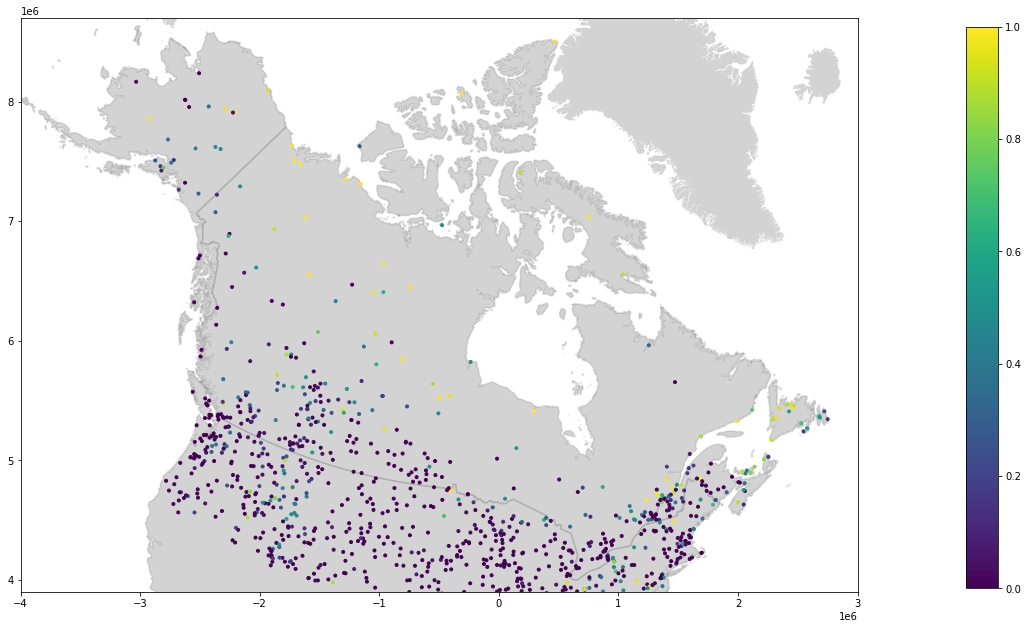

In [68]:
fig, ax = plt.subplots(figsize=(15,15))
ax.axis([-4000000,3000000,3900000,8700000])
countries.to_crs(aea_crs).plot(ax=ax, color='lightgrey')
station_gdf.to_crs(aea_crs).plot(ax=ax, marker='.', zorder=10, column='daily_snow_frac', cmap='viridis')
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=0, vmax=1))
sm._A = []
cax = fig.add_axes([1, 0.24, 0.03, 0.52])
plt.colorbar(sm, cax=cax)
countries.to_crs(aea_crs).loc[countries['ADMIN']=='Canada'].boundary.plot(ax=ax, color='k', alpha=0.1)
countries.to_crs(aea_crs).loc[countries['ADMIN']=='United States of America'].boundary.plot(ax=ax, color='k', alpha=0.1)